# Конструирование и отбор признаков, подбор гиперпараметров модели
<font color=darkblue>Задача: Опредлить объявление о продажи машин будет популярно или нет, по среднему количеству просмотров в день. Эта информация(одно из применений) поможет позволить размещать на популярных страницах рекламные банеры. <br/>
Это задача бинарной классификации, т.к. классов 2 (популярно/нет). 

## 1. Подготовка данных 
<font color=darkblue>Загрузим данные по объявлениям о продажах автомобилей 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.float_format', lambda x: "%.2f" % x)
df = pd.read_csv(u'../data/auto.ru_data.csv')

In [2]:
print(df.shape)
df.head()

(20237, 23)


,Год выпуска,КПП,Привод,Пробег,Тип кузова,Состояние,Срок владения,Цвет,Руль,Владельцы,...,Модель,Город,Объем двигателя,Мощность двигателя,Двигатель,Цена,Дата,Количество дней,Просмотров всего,Просмотров в день
0,2012.00,механическая,передний,141000.00,внедорожник 5 дв.,Не требует ремонта,NaN,белый,Левый,2 владельца,...,ix35 I,Воронеж,2.00,150.00,Бензин,790000,2018-06-25,60,387.00,6.45
1,2014.00,автоматическая,полный,80189.00,внедорожник 5 дв.,Не требует ремонта,NaN,белый,Левый,3 или более,...,X1 I (E84) Рестайлинг 20d,Москва,2.00,184.00,Дизель,1368000,2018-06-25,60,657.00,10.95
2,2010.00,механическая,передний,143000.00,седан,Не требует ремонта,NaN,бежевый,Левый,3 или более,...,Logan I Рестайлинг,Воронеж,1.40,75.00,Бензин,320000,2018-06-25,60,470.00,7.83
3,2009.00,механическая,передний,126000.00,седан,Не требует ремонта,NaN,жёлтый,Левый,3 или более,...,Nexia I Рестайлинг,Россошь,1.50,80.00,Бензин,150000,2018-06-25,60,438.00,7.30
4,2011.00,механическая,передний,159000.00,хэтчбек 5 дв.,Не требует ремонта,NaN,красный,Левый,3 или более,...,C4 II,Воронеж,1.60,120.00,Бензин,410000,2018-06-25,60,442.00,7.37


### Популярнось объявления
<font color=darkblue>Определять популярное объявление или нет мы будем по среднему количеству просмотров в день. Необходимо разделить выборку на 2 части. Для начала заполним пропущенные данные по просмотрам нулями.   

In [3]:
df['Просмотров в день']=df['Просмотров в день'].fillna(0).astype(int)

<font color=darkblue>Разделить выборку на равные части поможет процедура  describe(). 
Можно заметить, что граница 50% проходит на 10 просмотрах в день.


In [4]:
df.describe()

,Год выпуска,Пробег,Объем двигателя,Мощность двигателя,Цена,Количество дней,Просмотров всего,Просмотров в день
count,14739.00,14739.00,14738.00,14738.00,20237.00,20237.00,14738.00,20237.00
mean,2009.28,120236.89,2.04,147.37,1104596.17,21.09,672.09,14.58
std,5.75,77274.61,0.78,70.78,4807902.68,40.32,2391.36,21.38
min,1951.00,1.00,0.60,23.00,10000.00,1.00,1.00,0.00
25%,2007.00,70000.00,1.60,102.00,370000.00,1.00,113.00,0.00
50%,2011.00,108519.00,1.80,130.00,659900.00,11.00,246.00,10.00
75%,2013.00,158000.00,2.30,170.00,1249999.00,18.00,575.00,19.00
max,2018.00,1000000.00,6.60,612.00,661299008.00,772.00,99950.00,512.00


<font color=darkblue> Произведем дискретизацию, преобразуем непрерыную величину к двум классам. 

In [5]:
import numpy as np
df['Популярно'] = np.where(df['Просмотров в день'] >= 10, 'yes', 'no')


<font color=darkblue>Перемешаем данные(функция pd.sample , параметр frac позволяет получить случайную подвыборку, для ускорения времени обучения). 

Проверим разбиение разбивает выборку пополам   

In [6]:
df = df.sample(frac=0.25, random_state=0).reset_index(drop=True)
df['Популярно'].value_counts()

yes    2562
no     2497
Name: Популярно, dtype: int64

<font color=darkblue>Удалим прогнозируемую колонку из набора обучающих данных

In [7]:
y=df['Популярно']
df=df.drop(columns=['Популярно'])

## 2. Преобразуем наш датафрейм в массив признаков 
<font color=darkblue>воспользуемся dummy кодированием. Оно игнорирует числовые колонки, оставляя их без изменения и не включает текстовые атрибуты. 

Дополнительно создадим колонку с числом символов в объявлении, подробный текст может влиять на просматриваемость. 

In [8]:
df['Символов в объявлении']=df['Комментарий'].str.len()
df_dummy = pd.get_dummies(df)
df_dummy=df_dummy.fillna(0)
df_dummy.columns[33:]

Index(['Тип кузова_фургон', 'Тип кузова_хэтчбек 3 дв.',
       'Тип кузова_хэтчбек 4 дв.', 'Тип кузова_хэтчбек 5 дв.',
       'Состояние_Не требует ремонта', 'Срок владения_1 год',
       'Срок владения_1 год и 1 месяц', 'Срок владения_1 год и 10 месяцев',
       'Срок владения_1 год и 11 месяцев', 'Срок владения_1 год и 2 месяца',
       ...
       'Дата_2018-08-08', 'Дата_2018-08-09', 'Дата_2018-08-10',
       'Дата_2018-08-11', 'Дата_2018-08-12', 'Дата_2018-08-13',
       'Дата_2018-08-14', 'Дата_2018-08-15', 'Дата_2018-08-16',
       'Дата_2018-08-23'],
      dtype='object', length=6211)

<font color=darkblue>Разобьем массив получившихся признаков на 2 части. на обучающий набор и на тестовый

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_dummy, y, test_size=0.2,random_state=0)
X_train.shape

(4047, 6244)

In [10]:
X_test.shape

(1012, 6244)

<font color=darkblue>применим логистическую регрессию и анализируем результат 

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
clf = LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)
print(classification_report(y_predicted, y_test))
print('Accuracy',accuracy_score(y_predicted, y_test)) 

              precision    recall  f1-score   support

          no       1.00      1.00      1.00       515
         yes       1.00      1.00      1.00       497

   micro avg       1.00      1.00      1.00      1012
   macro avg       1.00      1.00      1.00      1012
weighted avg       1.00      1.00      1.00      1012

Accuracy 1.0


### Мы достигли максимальной точности , алгоритм не дает ни одной ошибки. Отличный результат!!! 
<font color=darkblue>НО, скорее всего существуют признаки от которых зависит целевая переменная Y, алгоритму машинного обучения очень просто обнаружить такие зависимости. 

In [107]:
df.columns

Index(['Год выпуска', 'КПП', 'Привод', 'Пробег', 'Тип кузова', 'Состояние',
       'Срок владения', 'Цвет', 'Руль', 'Владельцы', 'ПТС', 'Комментарий',
       'Марка', 'Модель', 'Город', 'Объем двигателя', 'Мощность двигателя',
       'Двигатель', 'Цена', 'Дата', 'Количество дней', 'Просмотров всего',
       'Просмотров в день', 'Символов в объявлении'],
      dtype='object')

<font color=darkblue>Проверим список колонок и удалим те которые могут яным образом влиять на результат. 

In [108]:
df = df.drop(columns=['Просмотров в день','Просмотров всего','Количество дней','Дата'])

In [109]:
df_dummy = pd.get_dummies(df).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(df_dummy, y, test_size=0.2,random_state=0)

In [110]:
clf = LogisticRegression(penalty='l1')

clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)
print(classification_report(y_predicted, y_test))
print('Accuracy',accuracy_score(y_predicted, y_test)) 

              precision    recall  f1-score   support

          no       0.70      0.84      0.77       428
         yes       0.87      0.74      0.80       584

   micro avg       0.78      0.78      0.78      1012
   macro avg       0.78      0.79      0.78      1012
weighted avg       0.80      0.78      0.78      1012

Accuracy 0.7816205533596838


<font color=darkblue>Давайте перепопробуем все алгоритмы со значениями по умолчанию и сравним результат:
- "k-ближайших соседей"
- "Линейный SVM" 
- "наивный баес"
- "Решающие деревья" 
- "Случайный лес"
- "Нейронные сети"
- "Логистическая регрессия"

Подключим библиотеки алгоритмов

In [111]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

<font color=darkblue>С алгоритмами можно работать универсальным образом, что очень удобно, проверим время выполнения каждого. Сравните время выполнения и качество прогноза с параметрами по умолчанию. 

In [112]:
import time
names = ["k-Соседей",
    "Линейный SVM", "Наивный баес",
         "Решающие деревья", "Случайный лес", "Нейронные сети", "Логистическая регрессия"]

classifiers = [
    KNeighborsClassifier(),
    LinearSVC(),GaussianNB(),DecisionTreeClassifier(),
    RandomForestClassifier(),MLPClassifier(hidden_layer_sizes=(50,)),LogisticRegression()]

scores=[]
scores_train=[]
times=[]
for name, clf in zip(names, classifiers): 
    start_time=time.time()
    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)
    scores.append( accuracy_score(y_predicted, y_test)  )
    scores_train.append( accuracy_score(clf.predict(X_train), y_train) )
    times.append(time.time() -start_time )

<font color=darkblue>Визуализируем результаты показателя "accuracy". причем отобразим одновременно и резульаты на обучающей выборке(синим) и на тестовой. Какие алгоритмы переобучились?   

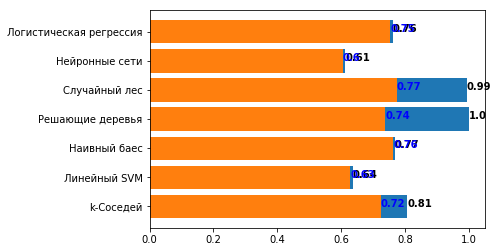

In [113]:
%matplotlib inline
from matplotlib import pylab as plt
plt.barh(names,scores_train)
for i, v in enumerate(scores_train):
    plt.text(v , i , str(round(v,2)), color='black', fontweight='bold')
plt.barh(names,scores)
for i, v in enumerate(scores):
    plt.text(v , i , str(round(v,2)), color='blue', fontweight='bold')

<font color=darkblue>Время выполнения каждого алгоритма. Сравните их между собой(если увеличить размер обучающей выборки то пропорция значительно поменяется)

<BarContainer object of 7 artists>

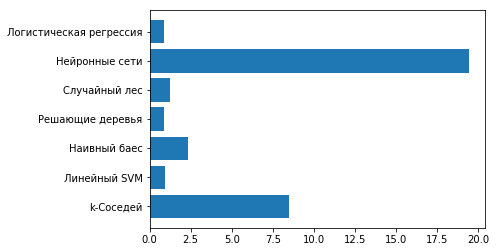

In [114]:
plt.barh(names,times)

# 3. Получили baseline который попробуем улучшить 
<font color=darkblue>Обратите внимание что все алгоритмы дают примерно одинаковый результат на тесте, SVM (очень мощного алгоритма)
проблема линейного алгоритма в том что вещественный признаки отличаются по масштабу от большинства справочных данных, закодированных Dummy.  

## 3.1. Заполнение пустых значений в данных 

<font color=darkblue>проверим кол-во пустых значений, если данных достуточно то часто используют удаление строк где есть хоть одно пустое 
значение атрибута 

In [115]:
for feature in df.columns:
    number = len(df) - len(df[df.isnull().apply(lambda x: not(x[feature]), axis=1)])
    print("{0:20} - {1} пустых значений.".format(feature, number))

Год выпуска          - 1365 пустых значений.
КПП                  - 1365 пустых значений.
Привод               - 1365 пустых значений.
Пробег               - 1365 пустых значений.
Тип кузова           - 1365 пустых значений.
Состояние            - 1365 пустых значений.
Срок владения        - 3490 пустых значений.
Цвет                 - 1365 пустых значений.
Руль                 - 1521 пустых значений.
Владельцы            - 1425 пустых значений.
ПТС                  - 1365 пустых значений.
Комментарий          - 239 пустых значений.
Марка                - 0 пустых значений.
Модель               - 0 пустых значений.
Город                - 103 пустых значений.
Объем двигателя      - 1366 пустых значений.
Мощность двигателя   - 1366 пустых значений.
Двигатель            - 1366 пустых значений.
Цена                 - 0 пустых значений.
Символов в объявлении - 239 пустых значений.


 ### 3.1.1. Категориальные признаки
<font color=darkblue> Заполнение пустых значений у категориальных признаков на отдельное значение справочника
 
 Также возможно применение стратегии замены на самое частоиспользуемое значение.
  

In [116]:
df["КПП"] = df["КПП"].fillna("empty")
df["Привод"] = df["Привод"].fillna("empty")
df["Тип кузова"] = df["Тип кузова"].fillna("empty")
df["Состояние"] = df["Состояние"].fillna("empty")
df["Цвет"] = df["Цвет"].fillna("empty")
df["Руль"] = df["Руль"].fillna("empty")
df["Владельцы"] = df["Владельцы"].fillna("empty")
df["ПТС"] = df["ПТС"].fillna("empty")
df["Город"] = df["Город"].fillna("empty")
df["Двигатель"] = df["Двигатель"].fillna("empty")
df["Срок владения"] = df["Срок владения"].fillna("empty")

### 3.1.2. Вещественные признаки
<font color=darkblue>существует множество вариантов, самые популярные:
- замена средним значением по всей выборке 
- матричные преобразования
- замена значением по методу k-ближайших значений 
- замена нулем 
- em-алшоритм
- интерполяция 

#### 3.1.2.1 Применим dummy кодирование
<font color=darkblue>для этого нужно перевести вещественные признаки к строковому значению. и тогда NaN будет отдельным признаком 

In [117]:
df_allstr=df.astype(str)
df_allstr = pd.get_dummies(df_allstr)
df_allstr.shape

(5059, 11699)

<font color=darkblue>Почти в 2 раза увеличилось число признаков, но посчитаем на тестовой выборке для всех моделей 

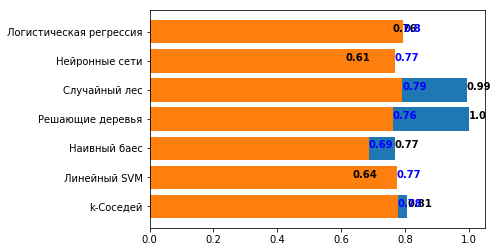

In [118]:
X_train, X_test, y_train, y_test = train_test_split(df_allstr, y, test_size=0.2,random_state=0)

scores=[]
times=[]
for name, clf in zip(names, classifiers):
    start_time=time.time() 
    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)
    scores.append( accuracy_score(y_predicted, y_test)  ) 
    
    times.append(time.time() -start_time )

plt.barh(names,scores_train)
for i, v in enumerate(scores_train):
    plt.text(v , i , str(round(v,2)), color='black', fontweight='bold')
    
plt.barh(names,scores)
for i, v in enumerate(scores):
    plt.text(v , i , str(round(v,2)), color='blue', fontweight='bold')


<BarContainer object of 7 artists>

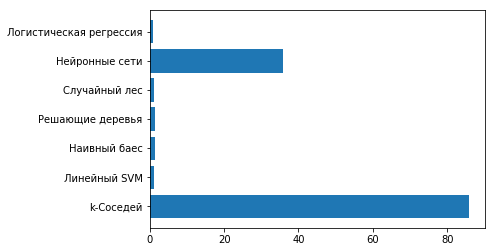

In [119]:
plt.barh(names,times)

<font color=darkblue>Линейные методы значительно улучшили свои показатели особенно(SVN), но время выполнения стало очень длительным из-за числа признаков, необходимо сократить их, выполняя отбор признаков

In [120]:
print('Количество признаков', df_allstr.columns.shape[0])

Количество признаков 11699


#### 1.2.2 Применим интерполяцию преобразование числовых признаков 
<font color=darkblue>- замену пустых на интерполированное значение

<font color=darkblue>- преобразование к отрезку (0,1)

<font color=darkblue>Воспользуемся методом interpolate который входит в состав библиотеки pandas для замены пустых значений

In [121]:
interp = df[["Цена", "Пробег", "Год выпуска", "Объем двигателя", "Мощность двигателя","Символов в объявлении"]]

interp = interp.sort_values(by="Цена")
interp.tail()

,Цена,Пробег,Год выпуска,Объем двигателя,Мощность двигателя,Символов в объявлении
1193,8776882,nan,nan,nan,nan,6627.00
3185,9770000,nan,nan,nan,nan,2801.00
2214,10024680,nan,nan,nan,nan,1563.00
1444,10052855,2206.00,2018.00,3.00,367.00,3552.00
464,13700000,7016.00,2016.00,5.20,610.00,1138.00


In [122]:
interp = interp.interpolate(method="linear")
interp.tail()

,Цена,Пробег,Год выпуска,Объем двигателя,Мощность двигателя,Символов в объявлении
1193,8776882,8850.77,2017.54,3.39,387.31,6627.00
3185,9770000,6635.85,2017.69,3.26,380.54,2801.00
2214,10024680,4420.92,2017.85,3.13,373.77,1563.00
1444,10052855,2206.00,2018.00,3.00,367.00,3552.00
464,13700000,7016.00,2016.00,5.20,610.00,1138.00


<font color=darkblue>для приведения к отрезку (0,1) воспользуемся метод MinMaxScaler

In [123]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(interp)
interp = pd.DataFrame(scaler.transform(interp), columns=["Цена", "Пробег", "Год выпуска", "Объем двигателя", "Мощность двигателя","Символов в объявлении"])

<font color=darkblue>Заменим исходные колонки на преобразованные 

In [124]:
df_interp = df.copy()
df_interp[["Цена", "Пробег", "Год выпуска", "Объем двигателя", "Мощность двигателя","Символов в объявлении"]] =\
    interp[["Цена", "Пробег", "Год выпуска", "Объем двигателя", "Мощность двигателя","Символов в объявлении"]]
df_interp.head()

,Год выпуска,КПП,Привод,Пробег,Тип кузова,Состояние,Срок владения,Цвет,Руль,Владельцы,ПТС,Комментарий,Марка,Модель,Город,Объем двигателя,Мощность двигателя,Двигатель,Цена,Символов в объявлении
0,0.58,empty,empty,0.13,empty,empty,empty,empty,empty,empty,empty,выгода до 200000 руб. по программе трейд-ин+кр...,Toyota,RAV 4 IV (CA40) Рестайлинг,Санкт-Петербург,0.07,0.02,empty,0.00,0.03
1,0.52,empty,empty,0.23,empty,empty,empty,empty,empty,empty,empty,"Комплектация КЛАССИК.- Ручки дверей, зеркала з...",УАЗ,Pickup I Рестайлинг 2,Красноярск,0.10,0.04,empty,0.00,0.00
2,0.29,empty,empty,0.15,empty,empty,empty,empty,empty,empty,empty,Автосалон Модус официальный дилер Nissan в гор...,Nissan,Qashqai II,Сочи,0.08,0.04,empty,0.00,0.01
3,0.57,механическая,передний,0.10,хэтчбек 5 дв.,Не требует ремонта,empty,серебристый,Левый,3 или более,Оригинал,В отличном состоянии. Автомобиль обслуживался ...,Ford,Focus II Рестайлинг,Москва,0.10,0.04,Бензин,0.00,0.00
4,0.75,empty,empty,0.00,empty,empty,empty,empty,empty,empty,empty,"Экстерьер: Топливный бак 66 л,Интерьер: Индика...",Mercedes-Benz,GLC Coupe C253 250 d,Краснодар,0.15,0.09,empty,0.00,0.00


In [125]:
df_interp = pd.get_dummies(df_interp)
print('Количество признаков', df_interp.columns.shape[0])

Количество признаков 6056


<font color=darkblue>Количество признаков как в исходном случае. расчитаем точность для всех алгоритмов 

In [126]:
X_train, X_test, y_train, y_test = train_test_split(df_interp, y, test_size=0.2,random_state=0)

scores=[]
times=[]
for name, clf in zip(names, classifiers):
    start_time=time.time() 
    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)
    scores.append( accuracy_score(y_predicted, y_test)  ) 
    times.append(time.time() -start_time )


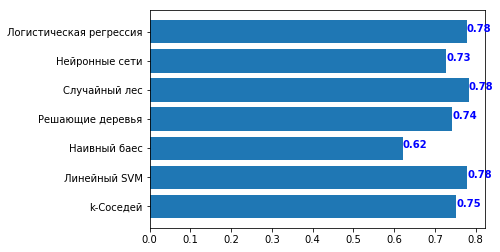

In [127]:
plt.barh(names,scores)
for i, v in enumerate(scores):
    plt.text(v , i , str(round(v,2)), color='blue', fontweight='bold')

<font color=darkblue>Дополнительно можно проводить биндинг и дискретизацию вещественных значений, когда мы признаком делаем не каждое число,
а диапазон. Но в данном примере это не приволит к улучшению. 

## 3.2. Отбор признаков на основании модели 
<font color=darkblue>отбор признаков может проводиться на основании:
- одномерных статистик 
- отбор признаков на основании модели 
- итерационный отбор признаков(итерационный отбор применяется для небольшого числа признаков, метод очень трудоемок) 

Применим отбор "признаков на основании модели(feature_selection.SelectFromModel)" с применением классификатора RandomForestClassifier. 
на вход подставляем данные df_allstr (пример где мы закодировали вещественные признаки отдельными справочниками) и ограничим количество признаков до значения 200 

In [128]:
X_train, X_test, y_train, y_test = train_test_split(df_allstr, y, test_size=0.2,random_state=0)

from sklearn.feature_selection import SelectFromModel

select = SelectFromModel(RandomForestClassifier(),max_features=200)

%time select.fit(X_train,y_train)

CPU times: user 1.34 s, sys: 86 ms, total: 1.42 s
Wall time: 1.3 s


SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        max_features=200, norm_order=1, prefit=False, threshold=None)

In [129]:
print('отобрано признаков: ',np.count_nonzero(select.get_support()==True))

отобрано признаков:  200


In [130]:
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

## 4. Проверим качество на отобранных признаках выберем модель для оптимизации

In [131]:
X_train_select=select.transform(X_train)
X_test_select=select.transform(X_test)

In [132]:
scores=[]
times=[]
for name, clf in zip(names, classifiers):
    start_time=time.time() 
    clf.fit(X_train_select, y_train)
    y_predicted = clf.predict(X_test_select)
    scores.append( accuracy_score(y_predicted, y_test)  ) 
    times.append(time.time() -start_time )

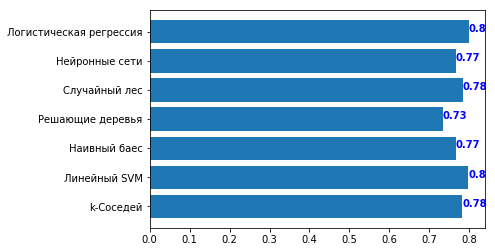

In [133]:
plt.barh(names,scores)
for i, v in enumerate(scores):
    plt.text(v , i , str(round(v,2)), color='blue', fontweight='bold')

In [134]:
X_train_select.shape

(4047, 200)

## 5 Проведем поиск по гиперпараметрам (gridsearch)
<font color=darkblue>возьмем для оптимизацию логистическую регресию с, зададим массив параметров  

In [135]:
from sklearn.model_selection import GridSearchCV
svc = LogisticRegression()
parameters = [{"penalty": ["l1","l2"],
              "C": [10**i for i in range(-3, 4)],
              "solver": [  "liblinear",  "saga"]}]

svc_clf = GridSearchCV(svc, parameters, cv=3)
svc_clf.fit(X_train_select, y_train)
svc_clf.best_score_

0.8065233506300964

<font color=darkblue>Лучшие параметры модели:

In [136]:
svc_clf.best_params_

{'C': 1000, 'penalty': 'l2', 'solver': 'liblinear'}

<font color=darkblue>Результат необходимо проверить на тестовой(контрольной) выборке. 

In [153]:
clf=LogisticRegression(**svc_clf.best_params_)
clf.fit(X_train_select, y_train)
y_predicted = clf.predict(X_test_select)
accuracy_score(y_predicted, y_test)  


0.7984189723320159

## 6. Применим популярные промышленные решения 
<font color=darkblue>xgboost и catboost от Яндекс, который позволяют в том числе использовать GPU 

загрузим библиотеки 

In [154]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

#### XGBoost
<font color=darkblue>на вход подадим отобранные признаки 

In [155]:
clf = XGBClassifier()
clf.fit(X_train_select, y_train)

y_predicted = clf.predict(X_test_select)
print(classification_report(y_predicted, y_test))
print('Accuracy',accuracy_score(y_predicted, y_test)) 

              precision    recall  f1-score   support

          no       0.63      0.95      0.76       346
         yes       0.96      0.72      0.82       666

   micro avg       0.80      0.80      0.80      1012
   macro avg       0.80      0.83      0.79      1012
weighted avg       0.85      0.80      0.80      1012

Accuracy 0.7954545454545454


#### CatBoost
<font color=darkblue>Обратите внимание что catboost может работать с начальным датасетом, не проводя кодирование и преобразований, достаточно только:
- закодировать Y числами 
- удалить поле "Комментарий"

In [156]:
df_train = df.iloc[y_train.index].drop(columns=["Комментарий"])
df_test = df.iloc[y_test.index].drop(columns=["Комментарий"])
y_train_01 = np.where(y_train == 'yes',1,0)
y_test_01 = np.where(y_test == 'yes',1,0)

<font color=darkblue>- указать cat_features - номера колонок содержащие категориальные значения
- определить параметр nan_mode стратегию обработки пустых строк, 

Возможнные значения параметра nan_mode:
- "Forbidden" — NaN values are not supported, their presence raises an exception.
- "Min" — Each NaN float feature is processed as the minimum value from the dataset.
- "Max" — Each NaN float feature is processed as the maximum value from the dataset.

In [157]:
cat_features = [df_train.columns.get_loc(x) for x in ["КПП", "Привод", "Тип кузова", "Состояние", "Срок владения", "Цвет", 
                                                      "Руль", "Владельцы", "ПТС","Марка", "Модель", "Город", "Двигатель"]]

clf = CatBoostClassifier(nan_mode="Min")
clf.fit(df_train, y_train_01  , cat_features=cat_features, logging_level="Silent")

y_predicted = clf.predict(df_test)
print(classification_report(y_predicted, y_test_01))
print('Accuracy', accuracy_score(y_predicted, y_test_01))

              precision    recall  f1-score   support

         0.0       0.70      0.87      0.77       417
         1.0       0.89      0.74      0.81       595

   micro avg       0.79      0.79      0.79      1012
   macro avg       0.79      0.80      0.79      1012
weighted avg       0.81      0.79      0.79      1012

Accuracy 0.7924901185770751


In [158]:
df_train.shape

(4047, 19)

<font color=darkblue>Мы применили catboost на исходных данных без преобразований и получили сопоставимый результат, используя только 19 начальных признаков 

## 7 Анализ точности и полноты 
<font color=darkblue>Дополнительные возможности мы получаем при анализе точности и полноты. изобразим какую точность мы может достигнуть при заданных уровнях полноты, для этого построим гривую точности и полноты для классификаторов :
<font color=darkblue>- "Наивный баес"
<font color=darkblue>- "Решающие деревья"
<font color=darkblue>- "Случайный лес"
<font color=darkblue>- "Логистическая регрессия"

    

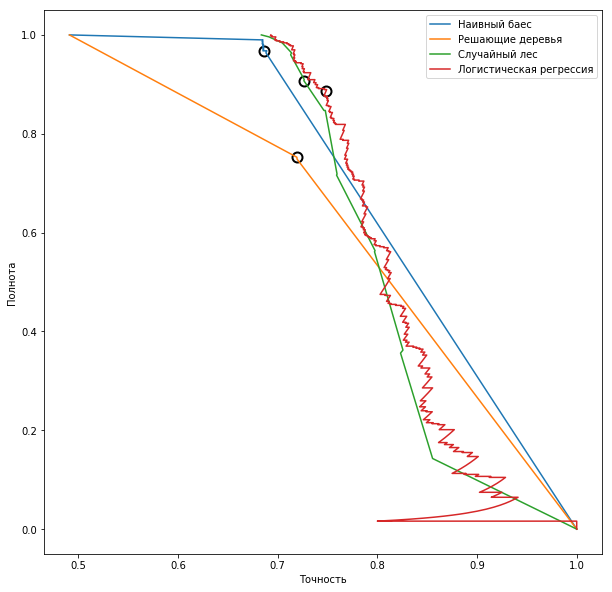

In [148]:
from sklearn.metrics import precision_recall_curve
class_dict = dict(zip(names, classifiers))
predict_proba_clfs = [ "Наивный баес", "Решающие деревья", 
                     "Случайный лес", "Логистическая регрессия"]

plt.figure(figsize=(10, 10))
plt.xlabel("Точность")
plt.ylabel("Полнота")

for i in range(7):
    name = names[i]
    clf = class_dict[name]

    if name in predict_proba_clfs:
        precision, recall, thresholds = precision_recall_curve(y_test_01, clf.predict_proba(X_test_select)[:, 1])

        close_zero = np.argmin(np.abs(thresholds - 0.5))
        plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, c='k', fillstyle="none", mew=2)
        plt.plot(precision, recall, label=name)

plt.legend(loc="best")
plt.show()

<font color=darkblue> На графике черный кружок означает значение точности и полноты при пороге по умолчанию = 0.5, далее мы увидим как можно использовать порог для подбора точности или полноты. 
Предположим мы хотим поощрять за популярное объявление и нам очень важно быть уверенными что объявление действительно популярно. Проверим "точность" для класса "популярно"

In [159]:
from sklearn.metrics import precision_recall_curve
clf=LogisticRegression().fit(X_train_select,y_train_01)
y_scores = clf.predict_proba(X_test_select)

precisions,recalls,thresholds = precision_recall_curve(y_test_01,y_scores[:, 1])

print("Точность", accuracy_score(clf.predict(X_test_select), y_test_01))
print(classification_report(clf.predict(X_test_select), y_test_01))

Точность 0.7984189723320159
              precision    recall  f1-score   support

           0       0.71      0.87      0.78       423
           1       0.89      0.75      0.81       589

   micro avg       0.80      0.80      0.80      1012
   macro avg       0.80      0.81      0.80      1012
weighted avg       0.81      0.80      0.80      1012



In [160]:
y_scores.shape

(1012, 2)

<font color=darkblue> мы видим что предсказываем попурятный класс с вероятностью 89 процентов, нам этого недостаточно, попробуем увеличить точность, для этого построим график зависимости точности и полноты от порога. 

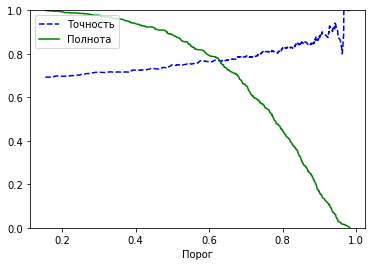

In [161]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],'b--',label='Точность')
    plt.plot(thresholds,recalls[:-1],'g-',label='Полнота')
    plt.xlabel('Порог')
    plt.legend(loc='upper left')
    plt.ylim([0,1])


plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

<font color=darkblue> Изменяем параметр "порог", установим в 0.25. Обратите внимание что общая точность даже немного повысилась и мы теперь предсказываем что класс популярен с точностью 99% что является очень высоким показателем уверенности.

In [162]:
print("Точность", accuracy_score(  (clf.predict_proba(X_test_select)[:,1] >= 0.25).astype(bool) , y_test_01))
print(classification_report((clf.predict_proba(X_test_select)[:,1] >= 0.25).astype(bool) , y_test_01))



Точность 0.7905138339920948
              precision    recall  f1-score   support

       False       0.60      0.98      0.75       317
        True       0.99      0.71      0.82       695

   micro avg       0.79      0.79      0.79      1012
   macro avg       0.79      0.84      0.78      1012
weighted avg       0.87      0.79      0.80      1012

